## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Старжевский Тимофей Евгеньевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

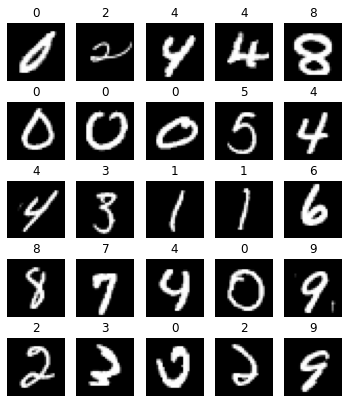

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [5]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

Теперь попробуем использовать инициализацию He:<br>
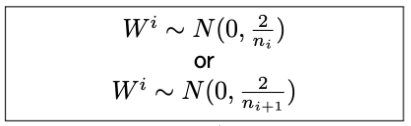

In [7]:
def test_network(network):
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()

Соберем все вместе, используя ReLU в качестве функции активации:

In [37]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / (28 * 28))
init_layer(layer_2, 0, 2 / 500)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

test_network(network)

forward 1.0103027820587158
forward 0.041402727365493774
backward 0.0221108291298151
backward 0.0007381998584605753


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

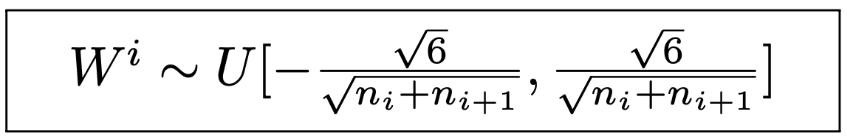

In [56]:
import math

layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

# init_layer(layer_1, 0, np.sqrt(1 / (28 * 28)))
# init_layer(layer_2, 0, np.sqrt(1 / 500 ))
# init_layer(layer_1, 0, math.sqrt(6) / math.sqrt(28*28 + 500))
# init_layer(layer_2, 0, math.sqrt(6) / math.sqrt(500 + 10))

init_layer(layer_1, -math.sqrt(6) / math.sqrt(28*28 + 500), math.sqrt(6) / math.sqrt(28*28 + 500))
init_layer(layer_2, -math.sqrt(6) / math.sqrt(500 + 10), math.sqrt(6) / math.sqrt(500 + 10))


network2 = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

test_network(network2)

forward 1.0103027820587158
forward 0.7840145826339722
backward 0.0221108291298151
backward 0.014030947349965572


In [57]:
print("Инициализация НЕ")
test_network(network)
print("================================")
print("Инициализация Xavier")
test_network(network2)

Инициализация НЕ
forward 1.0103027820587158
forward 0.041402727365493774
backward 0.0221108291298151
backward 0.0007381998584605753
Инициализация Xavier
forward 1.0103027820587158
forward 0.7840145826339722
backward 0.0221108291298151
backward 0.014030947349965572


#### Как видно, Xavier показывает сильно хуже результат

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

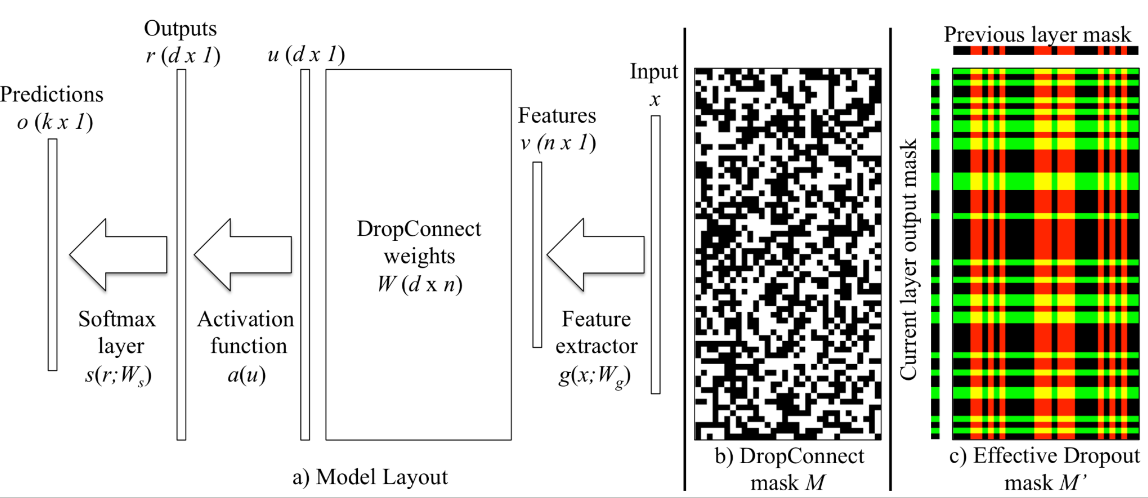

In [6]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand(self.linear.weight.size(), device=x.device) > self.p
        else:
            mask = torch.ones(self.linear.weight.size(), device=x.device)
        
        # mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [7]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [9]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

In [10]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [16]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314129
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.184605
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.740526
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.562097
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.378171
Test Epoch: 0	Loss: 0.632192
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.398181
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.410807
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373612
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.271896
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.123888
Test Epoch: 1	Loss: 0.406493
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224004
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.206593
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.134322
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.171632
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.082259
Test Epoch: 2	Loss: 0.322256
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.126177
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.160738
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.131903
Train Epoch: 3 [38400/60000 (64%)

### Добавим вспомогательные классы и функцию с графиками

In [26]:
import sys
from tqdm import tqdm
from IPython.display import clear_output

def train(model, optimizer, n_epochs=5, plot=True, verbose=True, validate_each=2, loss_fn=None, 
          train_dataloader=train_loader, val_dataloader=test_loader):
    # loss_fn = loss_fn or F.nll_loss
    loss_fn = loss_fn or F.cross_entropy

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    for epoch in range(n_epochs):
        train_loss = []
        train_accuracy = []
        # обучение
        print(f'Train epoch {epoch}', end=' ')
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.detach().numpy())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())
        
        train_loss_epochs.append(np.mean(train_loss))
        train_accuracy_epochs.append(np.mean(train_accuracy))

        # валидация
        if epoch % validate_each == 0 or (epoch + 1) % n_epochs == 0:
            print('\nValidate', end=' ')
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            clear_output(True)
            test_loss_epochs.append(np.mean(val_loss))
            test_accuracy_epochs.append(np.mean(val_accuracy))
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

In [27]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [43]:
drop_out_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

drop_connect_layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10),
]

drop_connect_layers_with_linear = [
    nn.Linear(196, 128),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    DropConnect(10, 10),
]

loss_fn = torch.nn.NLLLoss()

Epoch 4... (Train/Test) NLL: 0.192/0.168	Accuracy: 0.943/0.951

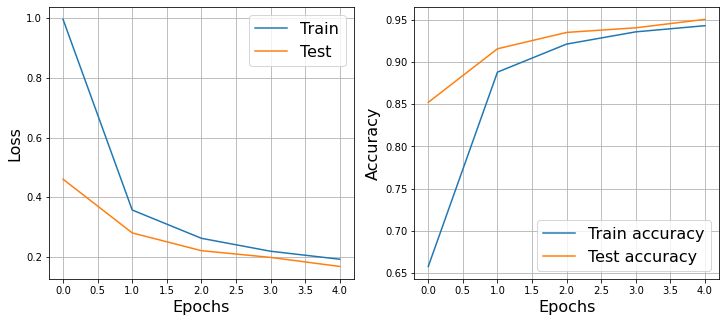

In [41]:
network = TestNetwork(nn.Sequential(*drop_out_layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
train(network, optimizer, loss_fn=loss_fn, validate_each=1)

Epoch 4... (Train/Test) NLL: 0.245/0.217	Accuracy: 0.923/0.930

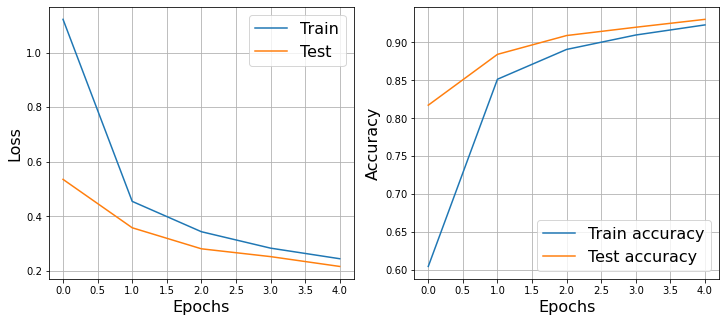

In [42]:
network = TestNetwork(nn.Sequential(*drop_connect_layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
train(network, optimizer, loss_fn=loss_fn, validate_each=1)

Epoch 4... (Train/Test) NLL: 0.453/0.415	Accuracy: 0.858/0.866

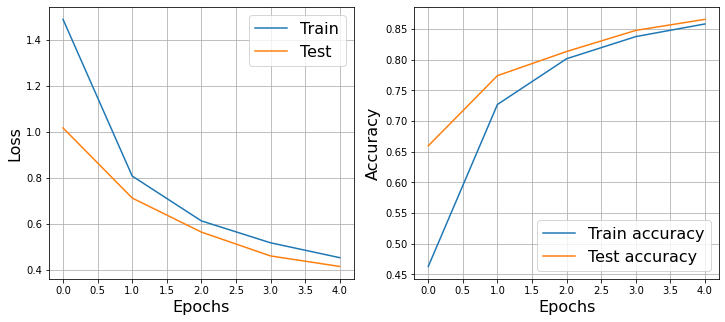

In [44]:
network = TestNetwork(nn.Sequential(*drop_connect_layers_with_linear))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
train(network, optimizer, loss_fn=loss_fn, validate_each=1)

### Выводы

- DropOut показывает более высокие результаты на точности и более низкую ошибку, чем DropConnect
- Оба метода хорошо обучают такую большую модель на столь малом числе эпох: 5
- Ради эксперимента добавил Linear слои перед DropConnect, хотя она внутри себя их также содержит, и получил гораздо хуже результаты, понял, что так делать не стоит)

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

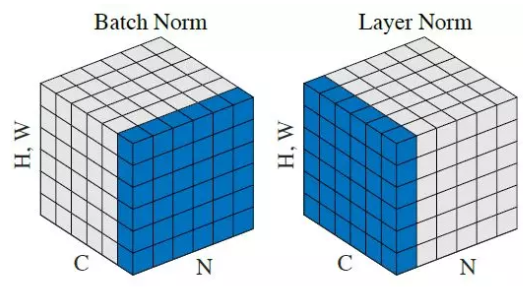

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [46]:
class LayerNormalization(nn.Module):
    def __init__(self, features, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        output = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return output

### Импортируем Batch Norm

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [49]:
layer_norm_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 10)
]

batch_norm_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

loss_fn = torch.nn.NLLLoss()

Epoch 4... (Train/Test) NLL: 0.067/0.086	Accuracy: 0.979/0.972

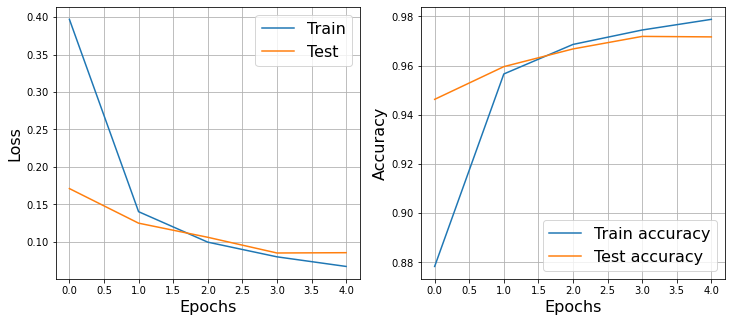

In [50]:
network = TestNetwork(nn.Sequential(*layer_norm_layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
train(network, optimizer, loss_fn=loss_fn, validate_each=1)

Epoch 4... (Train/Test) NLL: 0.057/0.089	Accuracy: 0.981/0.971

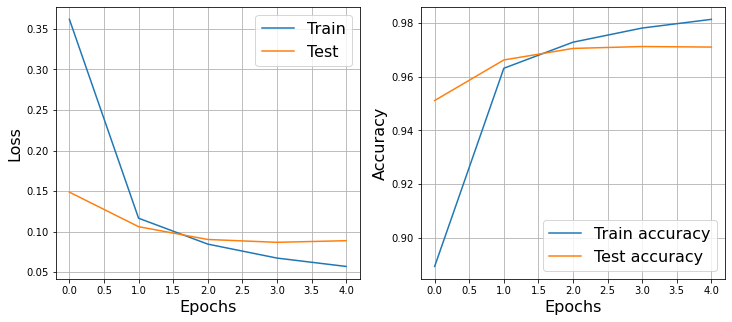

In [51]:
network = TestNetwork(nn.Sequential(*batch_norm_layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
train(network, optimizer, loss_fn=loss_fn, validate_each=1)

### Выводы

- В случае batch norm у нас точность на тестовой выборке начала падать, в то время как на трейн она продолжила увеличиваться. Loss также говорит о том, что мы переобучиваем модель на трейн выборке и она хуже справляется с тестовой.
- Layer norm показывает чуть лучше резульат точности, чуть ниже Loss, но совсем незначительно, и чуть позже начинает переобучиваться. Но в целом результаты схожи.